# Multiple Instance Learning

In [2]:
# Required libraries & packages
library(rstatix)
library(ggsignif)
library(data.table)
library(caret)
library(ranger)
library(rpart)
library(rattle)
library(glmnet)
library(tidyverse)
library(ggplot2)
library(factoextra)
library(cluster)
library(gbm)
library(randomForest)
library(dplyr) 
library(skimr)

In [3]:
# reading & renaming & showing data set
musk <- read.csv("Musk1.csv", header = FALSE)
setnames(musk, c("V1","V2"), c("BagClass","BagId"))
head(musk)

,BagClass,BagId,V3,V4,V5,V6,V7,V8,V9,V10,...,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1,42,-198,-109,-75,-117,11,23,-88,...,-238,-74,-129,-120,-38,30,48,-37,6,30
2,1,1,42,-191,-142,-65,-117,55,49,-170,...,-238,-302,60,-120,-39,31,48,-37,5,30
3,1,1,42,-191,-142,-75,-117,11,49,-161,...,-238,-73,-127,-120,-38,30,48,-37,5,31
4,1,1,42,-198,-110,-65,-117,55,23,-95,...,-238,-302,60,-120,-39,30,48,-37,6,30
5,1,2,42,-198,-102,-75,-117,10,24,-87,...,-238,-73,-127,51,128,144,43,-30,14,26
6,1,2,42,-191,-142,-65,-117,55,49,-170,...,-238,-300,61,51,127,143,42,-31,14,26


In [4]:
# checking NA existence in data set
cal_na <-sapply(musk, function(y) sum(length(which(is.na(y)))))
t(cal_na) # Any NA columns were observed

BagClass,BagId,V3,V4,V5,V6,V7,V8,V9,V10,...,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Looking for data set in terms of row-column-overall
row = nrow(musk)
paste0("There are ",row, " rows")
col = ncol(musk)
paste0("There are ",col, " columns")
overall=str(musk)
head(overall)

[1] "There are 476 rows"

[1] "There are 168 columns"

'data.frame':	476 obs. of  168 variables:
 $ BagClass: int  1 1 1 1 1 1 1 1 1 1 ...
 $ BagId   : int  1 1 1 1 2 2 2 2 3 3 ...
 $ V3      : int  42 42 42 42 42 42 42 42 40 44 ...
 $ V4      : int  -198 -191 -191 -198 -198 -191 -190 -199 -173 -159 ...
 $ V5      : int  -109 -142 -142 -110 -102 -142 -142 -102 -142 -63 ...
 $ V6      : int  -75 -65 -75 -65 -75 -65 -75 -65 13 -74 ...
 $ V7      : int  -117 -117 -117 -117 -117 -117 -117 -117 -116 -117 ...
 $ V8      : int  11 55 11 55 10 55 12 55 -7 17 ...
 $ V9      : int  23 49 49 23 24 49 49 23 50 5 ...
 $ V10     : int  -88 -170 -161 -95 -87 -170 -161 -94 -171 -114 ...
 $ V11     : int  -28 -45 -45 -28 -28 -45 -45 -29 -44 -31 ...
 $ V12     : int  -27 5 -28 5 -28 6 -29 6 -103 -33 ...
 $ V13     : int  -232 -325 -278 -301 -233 -324 -277 -299 -321 -287 ...
 $ V14     : int  -212 -115 -115 -212 -212 -114 -114 -212 -117 -243 ...
 $ V15     : int  -66 -107 -67 -107 -67 -106 -68 -106 -242 -73 ...
 $ V16     : int  -286 -281 -274 -280 -286 -280

NULL

In [6]:
# Representation_1: k-medoids-euclidean and -manhattan distances
# Scaling step
scaled_musk <- scale(musk[,-c(1,2)])
head(scaled_musk) #the first two columns hold the bag class and ID, no need to be scaled.

V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,...,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168
0.180723,-0.8815999,-0.4301752,-1.203764,-0.1637934,0.2255951,0.3718827,-1.263585,0.6545626,0.6772360,...,-0.2581806,1.455964,-0.1702653,-1.444906,-0.8638585,-1.0098004,-0.7868047,-0.1792746,0.5558014,-0.06854306
0.180723,-0.8023368,-0.9072433,-1.071341,-0.1637934,0.7037235,0.6158746,-2.345572,0.4780699,1.1188121,...,-0.2581806,-1.089633,1.3815278,-1.444906,-0.8753112,-0.9895037,-0.7868047,-0.1792746,0.5385627,-0.06854306
0.180723,-0.8023368,-0.9072433,-1.203764,-0.1637934,0.2255951,0.6158746,-2.226817,0.4780699,0.6634368,...,-0.2581806,1.467129,-0.1538442,-1.444906,-0.8638585,-1.0098004,-0.7868047,-0.1792746,0.5385627,-0.05008916
0.180723,-0.8815999,-0.4446318,-1.071341,-0.1637934,0.7037235,0.3718827,-1.355949,0.6545626,1.1188121,...,-0.2581806,-1.089633,1.3815278,-1.444906,-0.8753112,-1.0098004,-0.7868047,-0.1792746,0.5558014,-0.06854306
0.180723,-0.8815999,-0.3289789,-1.203764,-0.1637934,0.2147286,0.3812670,-1.250390,0.6545626,0.6634368,...,-0.2581806,1.467129,-0.1538442,1.162267,1.0372846,1.3040163,-0.8920954,0.2576990,0.6937105,-0.14235866
0.180723,-0.8023368,-0.9072433,-1.071341,-0.1637934,0.7037235,0.6158746,-2.345572,0.4780699,1.1326113,...,-0.2581806,-1.067303,1.3897384,1.162267,1.0258320,1.2837197,-0.9131535,0.1952742,0.6937105,-0.14235866


In [7]:
# Calculation for both representations (euclidean and manhattan distance)
euclidean_d <- dist(scaled_musk, "euclidean")
euclidean_d <- as.data.table(as.matrix(euclidean_d))
manhattan_d <- dist(scaled_musk, "manhattan") 
manhattan_d <- as.data.table(as.matrix(manhattan_d))

In [8]:
head(euclidean_d)

1,2,3,4,5,6,7,8,9,10,...,467,468,469,470,471,472,473,474,475,476
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.000000,9.747368,6.420542,7.203768,6.354020,11.635096,9.137108,9.590817,11.865292,9.363132,...,24.89559,24.82110,18.01583,19.23653,19.87863,18.21749,18.74734,20.81649,19.28491,20.84309
9.747368,0.000000,7.188194,6.344397,11.634693,6.350102,9.688387,8.990337,10.855212,12.396573,...,24.14239,24.07228,18.13480,19.31686,19.80786,18.46470,18.70720,21.25206,19.86831,21.22435
6.420542,7.188194,0.000000,9.361300,9.034539,9.575952,6.472888,11.305678,9.898085,10.047022,...,24.51087,24.43712,17.78703,19.42830,20.08483,18.04464,18.29368,20.98707,19.41360,20.96826
7.203768,6.344397,9.361300,0.000000,9.608414,8.999367,11.414957,6.369983,12.512347,11.706965,...,24.44607,24.37123,18.44915,19.22510,19.69417,18.72826,19.22902,21.15243,19.81351,21.16607
6.354020,11.634693,9.034539,9.608414,0.000000,9.765246,6.498023,7.176369,9.700128,8.236632,...,24.21855,25.06942,16.69298,18.92306,18.85869,17.60464,17.51123,20.51787,18.04463,19.88013
11.635096,6.350102,9.575952,8.999367,9.765246,0.000000,7.200070,6.401336,8.401357,11.588551,...,23.44455,24.35601,16.77969,19.01950,18.79954,17.82195,17.42945,20.95556,18.67425,20.27500


In [9]:
head(manhattan_d)

1,2,3,4,5,6,7,8,9,10,...,467,468,469,470,471,472,473,474,475,476
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00000,80.25242,44.80421,36.51179,24.38245,103.64169,69.14326,60.40664,108.72150,73.63597,...,260.3760,253.6431,187.0307,203.4644,214.5860,189.9813,199.5858,216.6779,204.3739,223.0618
80.25242,0.00000,36.60197,44.72466,103.77557,24.37407,60.75329,68.53313,74.80429,116.91101,...,256.9685,250.5581,189.0188,203.2729,210.9892,188.7857,191.8320,217.3519,206.8390,225.4236
44.80421,36.60197,0.00000,74.33123,68.17230,60.25445,25.02425,97.93342,66.74015,84.43771,...,259.1815,252.5850,186.5070,204.1253,216.8111,185.1785,188.3651,216.6331,201.8728,224.1048
36.51179,44.72466,74.33123,0.00000,60.10242,68.36910,98.47165,24.80535,114.36047,103.48757,...,256.0527,249.4531,191.3196,204.2225,210.2616,195.3670,204.6962,219.2186,211.0186,225.9699
24.38245,103.77557,68.17230,60.10242,0.00000,82.07704,47.61392,36.77129,89.41058,66.60746,...,249.4623,261.1026,168.7263,200.6169,201.5857,182.5304,182.4337,213.8314,186.9839,210.3413
103.64169,24.37407,60.25445,68.36910,82.07704,0.00000,37.89867,46.30484,54.97816,110.26168,...,245.6820,258.0290,170.3926,200.3207,198.3046,181.1391,174.0085,214.4285,189.8695,212.6753


Warning message:
"Ignoring unknown parameters: type"


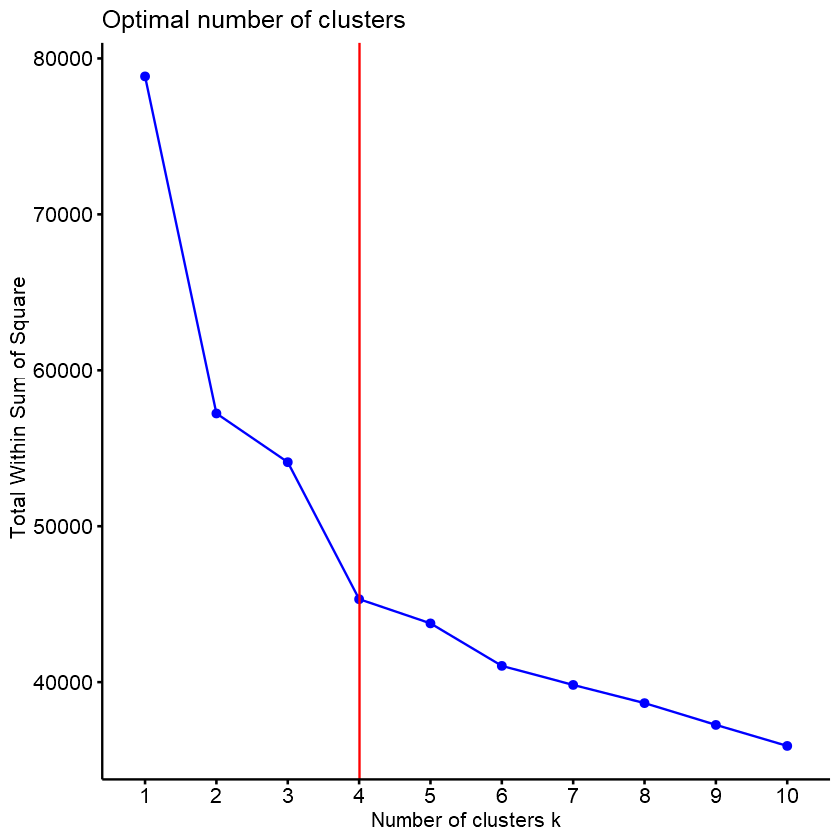

In [10]:
# Determination of ideal cluster number for euclidean distance representation
euclidean_icn <- fviz_nbclust(scaled_musk, pam, method = "wss")
fviz_nbclust(scaled_musk, pam, method = "wss", linecolor = "blue" ) + geom_vline(xintercept = 4, type = "o", col = "red")

In [11]:
cluster_result_euclidean <- euclidean_icn$data
glimpse(cluster_result_euclidean)

Rows: 10
Columns: 2
$ clusters <fct> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
$ y        <dbl> 78850.00, 57232.13, 54107.40, 45321.88, 43768.01, 41043.48, 3~


In [12]:
# Application of  k-medoids clustering method at k = 4 for euclidean distance representation
euclidean_kmedoids <- pam(scaled_musk, metric = "euclidean", k = 4)
summary(euclidean_kmedoids)

Medoids:
      ID         V3         V4         V5         V6         V7         V8
[1,]  12  0.1254375  0.2847002  0.2637420 -1.2037636 -0.1637934  0.2690613
[2,]  90  1.0652899 -0.5871941  0.4805911  0.1601865 -0.1637934 -0.9479927
[3,]  69  0.2360084  0.1714671  0.8420063 -0.9389189 -0.1637934  0.8558552
[4,] 108 -1.0355565 -0.8249834 -0.9795263  0.2263977 -0.1637934 -0.2959994
             V9        V10        V11        V12        V13        V14
[1,]  0.4375728 -2.2664022  0.8206733  0.7048345 -1.7800698 -1.6143436
[2,]  0.6346433 -0.1552072  0.5611253 -0.6474922  0.5501335  0.3747149
[3,] -1.4205197  0.1350821 -1.4841128  0.6634368  0.3605955 -0.1557007
[4,]  0.5971060 -0.1156223  0.4469242 -0.7440870  0.5278350  0.2782757
            V15         V16         V17        V18        V19        V20
[1,] 0.06983363 -2.15451667 -2.32539471 -0.6091391  0.1237210 -0.4516571
[2,] 0.23581133 -0.01585169  0.04779095 -0.2333937  0.6940542 -0.2222949
[3,] 0.03965586  0.27250764  0.04779095  0

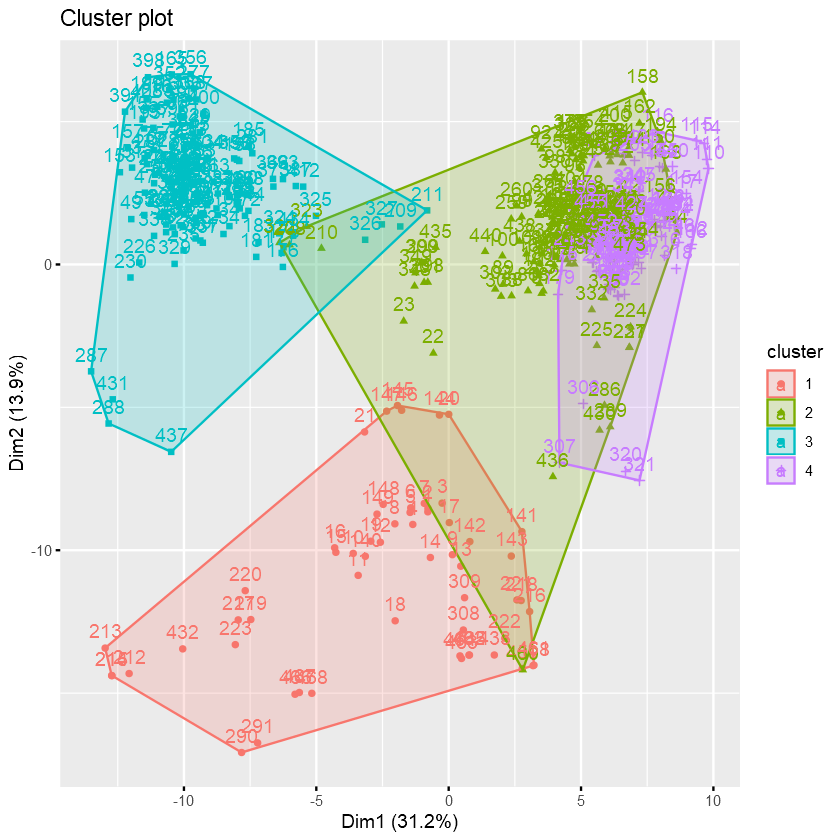

In [13]:
# Illustration of clusters with scatterplot 
fviz_cluster(euclidean_kmedoids, data = scaled_musk)

Warning message:
"Ignoring unknown parameters: type"


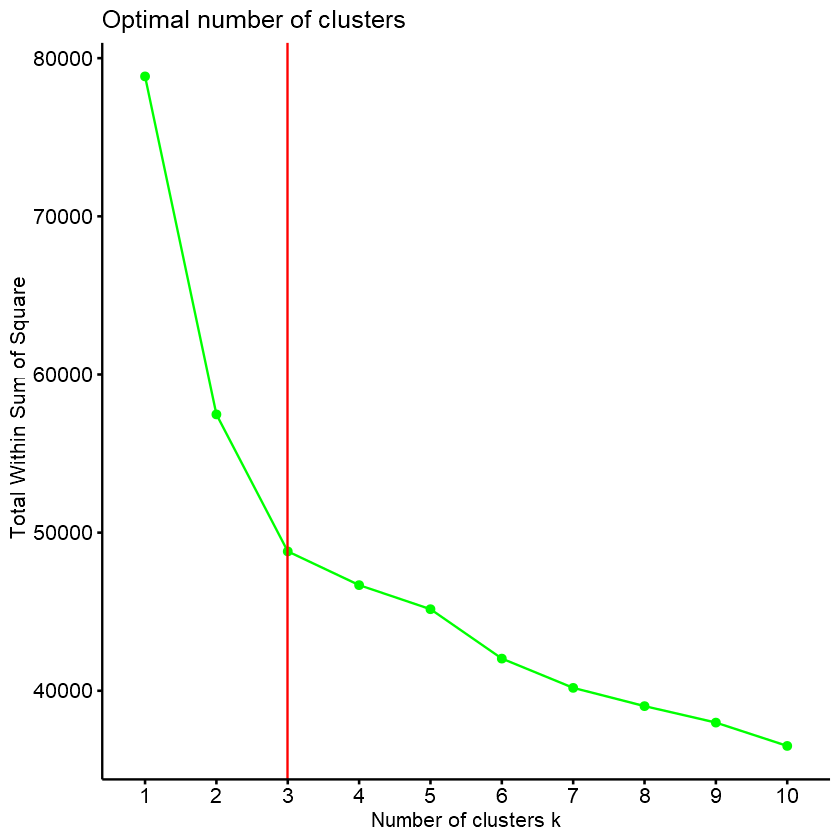

In [14]:
# Determination of ideal cluster number for manhattan distance representation
manhattan_icn <- fviz_nbclust(scaled_musk, pam, method = "wss", metric = "manhattan")
fviz_nbclust(scaled_musk, pam, method = "wss", metric = "manhattan", linecolor = "green" ) + geom_vline(xintercept = 3, type = "o", col = "red")

In [15]:
cluster_result_manhattan <- manhattan_icn$data
glimpse(cluster_result_manhattan)

Rows: 10
Columns: 2
$ clusters <fct> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
$ y        <dbl> 78850.00, 57477.77, 48814.96, 46682.79, 45159.62, 42036.02, 4~


In [16]:
# Application of  k-medoids clustering method at k = 3 for manhattan distance representation
manhattan_kmedoids <- pam(scaled_musk, metric = "manhattan", k = 3)
summary(manhattan_kmedoids)

Medoids:
     ID          V3         V4         V5         V6         V7         V8
[1,] 12  0.12543753  0.2847002  0.2637420 -1.2037636 -0.1637934  0.2690613
[2,] 60  0.78886272 -0.7910135 -0.6614809  0.1866710 -0.1637934 -0.8827933
[3,] 58 -0.04041876  0.1148506  0.8275497 -0.7800121 -0.1637934  0.5081255
             V9         V10        V11        V12       V13         V14
[1,]  0.4375728 -2.26640223  0.8206733 0.70483451 -1.780070 -1.61434360
[2,]  0.5971060  0.01632739  0.5507434 0.05626964  0.527835  0.53142862
[3,] -1.4017511  0.75524565 -1.3283840 0.62203899 -0.219168 -0.08337128
            V15        V16        V17        V18        V19        V20
[1,] 0.06983363 -2.1545167 -2.3253947 -0.6091391  0.1237210 -0.4516571
[2,] 0.70356666 -0.1480164  0.1395716 -0.4212664  0.8495996  0.2670109
[3,] 0.19054468  0.3205675  0.2969099 -0.3899543 -1.5181471  0.7716076
            V21        V22         V23        V24         V25        V26
[1,] -2.2455061 -2.0181973  0.28544609  0.4063

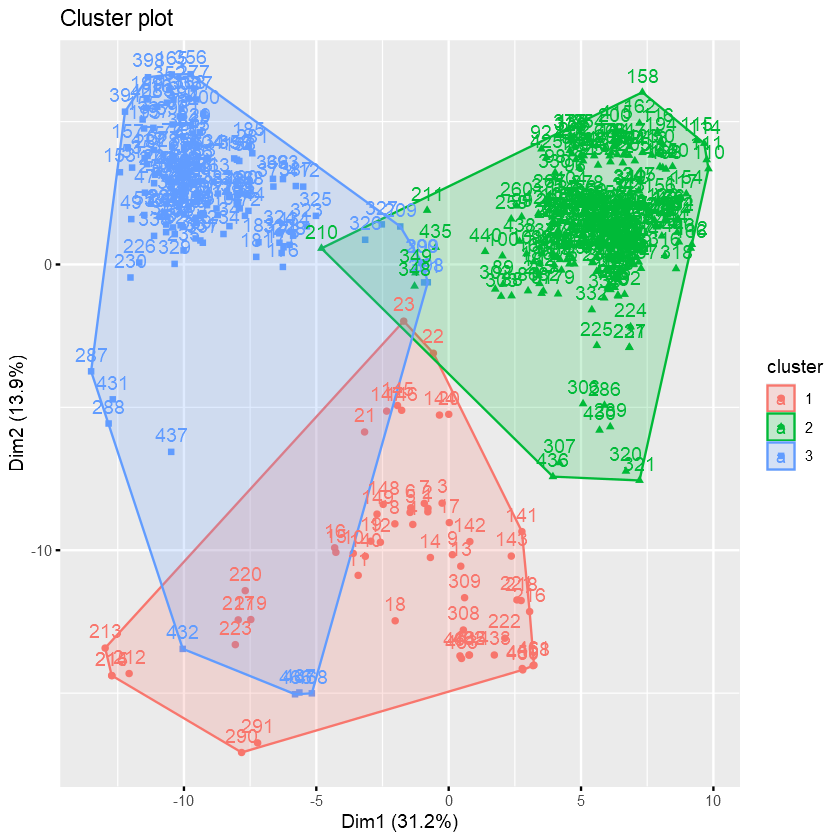

In [17]:
# Illustration of clusters with scatterplot 
fviz_cluster(manhattan_kmedoids, data = scaled_musk)

In [18]:
# Representation_1: euclidean distance with k=4
paste0("the average distances to 4 cluster centers")
euclidean_kmedoids$id.med # this gives us the average distances to cluster's center.
# Creation of four different features by the distance
mean_d_euc = c() 
mean_d_euc<-cbind(euclidean_d[,get(as.character(as.numeric(euclidean_kmedoids$id.med[1])))],
                  euclidean_d[,get(as.character(as.numeric(euclidean_kmedoids$id.med[2])))],
                  euclidean_d[,get(as.character(as.numeric(euclidean_kmedoids$id.med[3])))],
                  euclidean_d[,get(as.character(as.numeric(euclidean_kmedoids$id.med[4])))])
mean_d_euc <- as.data.table(mean_d_euc, mean_d_euc)
setnames(mean_d_euc, old = colnames(mean_d_euc), new = c("C1","C2","C3","C4"))
bag_euc <- as.data.table(cbind(musk[,1:2], mean_d_euc))
bag_mean_euc <- bag_euc %>% aggregate(., list(bag_euc$BagId), mean) %>% select(-Group.1)

[1] "the average distances to 4 cluster centers"

[1]  12  90  69 108

In [19]:
paste0("First representation of 4-mediods with euclidean distance")
head(bag_mean_euc)

[1] "First representation of 4-mediods with euclidean distance"

,BagClass,BagId,C1,C2,C3,C4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,8.171827,16.66629,18.87771,16.39061
2,1,2,9.674264,16.13365,18.58626,17.52873
3,1,3,9.719209,16.44523,18.72514,18.22199
4,1,4,5.867434,16.74637,19.05427,17.46591
5,1,5,15.401786,20.10263,21.89998,21.81525
6,1,6,10.078564,17.21602,19.83173,18.81168


In [20]:
paste0("Second representation of 4-mediods with euclidean distance")
tail(bag_mean_euc)

[1] "Second representation of 4-mediods with euclidean distance"

,BagClass,BagId,C1,C2,C3,C4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
87,0,87,24.50219,20.55036,20.23286,22.899532
88,0,88,19.00961,12.47712,20.14289,9.099134
89,0,89,18.70702,18.82363,25.59508,20.699871
90,0,90,16.07207,18.47011,23.71070,20.357047
91,0,91,24.28005,26.63296,24.64077,25.926869
92,0,92,19.30512,14.50194,15.21473,16.515298


In [21]:
# Representation_2: manhattan distance with k=3
paste0("the average distances to 3 cluster centers")
manhattan_kmedoids$id.med # this gives us the average distances to cluster's center.
# Creation of four different features by the distance
mean_d_man = c() 
mean_d_man<-cbind(manhattan_d[,get(as.character(as.numeric(manhattan_kmedoids$id.med[1])))],
                  manhattan_d[,get(as.character(as.numeric(manhattan_kmedoids$id.med[2])))],
                  manhattan_d[,get(as.character(as.numeric(manhattan_kmedoids$id.med[3])))])
mean_d_man <- as.data.table(mean_d_man, mean_d_man)
setnames(mean_d_man, old = colnames(mean_d_man), new = c("C1","C2","C3"))
bag_man <- as.data.table(cbind(musk[,1:2], mean_d_man))
bag_mean_man <- bag_man %>% aggregate(., list(bag_man$BagId), mean) %>% select(-Group.1)

[1] "the average distances to 3 cluster centers"

[1] 12 60 58

In [22]:
paste0("First representation of 3-mediods with manhattan distance")
head(bag_mean_man)

[1] "First representation of 3-mediods with manhattan distance"

,BagClass,BagId,C1,C2,C3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,65.33971,135.3678,163.0609
2,1,2,79.18382,154.5530,174.3088
3,1,3,83.22995,163.8854,191.2397
4,1,4,47.90798,153.7601,163.6228
5,1,5,102.21577,183.2572,212.7286
6,1,6,80.56845,177.3379,196.6622


In [23]:
paste0("Second representation of 3-mediods with manhattan distance")
tail(bag_mean_man)

[1] "Second representation of 3-mediods with manhattan distance"

,BagClass,BagId,C1,C2,C3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
87,0,87,228.2973,175.54375,171.5547
88,0,88,192.9529,88.51432,204.9829
89,0,89,167.3083,205.06490,278.5729
90,0,90,145.1546,206.37283,255.6596
91,0,91,257.4561,291.98836,251.1252
92,0,92,202.6035,145.66919,139.6826


In [24]:
# Classification_1: decision tree + Representation_1: euclidean distance
# For decision tree classification turning zeros and ones to factors
# for euclidean
bag_mean_euc$BagClass = ifelse(bag_mean_euc$BagClass == 1, "ob", "zb")
# for manhattan
bag_mean_man$BagClass = ifelse(bag_mean_man$BagClass == 1, "ob", "zb")

In [25]:
head(bag_mean_euc)

,BagClass,BagId,C1,C2,C3,C4
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ob,1,8.171827,16.66629,18.87771,16.39061
2,ob,2,9.674264,16.13365,18.58626,17.52873
3,ob,3,9.719209,16.44523,18.72514,18.22199
4,ob,4,5.867434,16.74637,19.05427,17.46591
5,ob,5,15.401786,20.10263,21.89998,21.81525
6,ob,6,10.078564,17.21602,19.83173,18.81168


In [26]:
head(bag_mean_man)

,BagClass,BagId,C1,C2,C3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ob,1,65.33971,135.3678,163.0609
2,ob,2,79.18382,154.5530,174.3088
3,ob,3,83.22995,163.8854,191.2397
4,ob,4,47.90798,153.7601,163.6228
5,ob,5,102.21577,183.2572,212.7286
6,ob,6,80.56845,177.3379,196.6622
